In [1]:
%matplotlib inline
import os, sys, time
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# load the raw data
df = pd.read_csv('./data/train.csv')
print('Shape of the dataset: {}'.format(df.shape))
df.head()

Shape of the dataset: (595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# is there class imbalance? The answer is very much..., it's 3.6%
df['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [5]:
# what features are we looking at?
# there are 57 features in total (=59-2)
all_features = df.columns.tolist()
all_features.remove('target')
all_features.remove('id')
bin_features = []
cat_features = []
other_features = []
for col in df.columns:
    if col.split('_')[-1] == 'bin':
        bin_features.append(col)
    elif col.split('_')[-1] == 'cat':
        cat_features.append(col)
    else:
        other_features.append(col)

In [6]:
len(bin_features)

17

In [7]:
len(cat_features)

14

In [50]:
# how many missing values, in terms of percentage, are we looking at?
df[['target']+all_features].groupby('target')[all_features]\
.apply(lambda x: 100*np.sum(x == -1)/len(x)).T

target,0,1
ps_ind_01,0.0,0.0
ps_ind_02_cat,0.0,0.0
ps_ind_03,0.0,0.0
ps_ind_04_cat,0.0,0.0
ps_ind_05_cat,0.0,0.0
ps_ind_06_bin,0.0,0.0
ps_ind_07_bin,0.0,0.0
ps_ind_08_bin,0.0,0.0
ps_ind_09_bin,0.0,0.0
ps_ind_10_bin,0.0,0.0


In [ ]:
# replace the -1 with NaN, so that I can use pandas.dropna...
df.replace({-1: np.float('NaN')}, inplace=True)

In [53]:
# how to deal with those missing (-1) values? 
# what if I just drop them?
print(df['target'].value_counts())  # classes before dropna
df.dropna(how='any', inplace=True)
print(df['target'].value_counts())  # classes after dropna

0    573518
1     21694
Name: target, dtype: int64
0    119261
1      5670
Name: target, dtype: int64


In [54]:
5670 / (5670+119261)

0.04538505254900705

In [79]:
# let's handle everything in a class
class Classifier():
    '''
    In this class, we will do everything, including:
    (1) data cleaning, imputation, scaling
    (2) possible feature engineering
    (3) model fitting, including CV 
    (4) prediction on test data
    (5) helper functions such as various plotting functions
    
    Here we heavily rely on the pandas, hence most of the datatypes is pandas dataframe
    '''
    def __init__(self, X_raw, y_raw):
        '''
        Initialization.
        Here we assume there is no missing entry (with value of -1)
        in the data, i.e., we've done the data cleaning step.
        
        Input
        =====================
        X_raw: <pandas dataframe> 
            The raw input, in pandas dataframe. 
            The shape should be m x n,
            where m is the number of sample, n is the number of features
        Y_raw: <pandas dataframe>
            The raw binary labels, in pandas dataframe.
            The shape should be m x 1
            
        Return
        =====================
        Nothing
        '''
        import time
        
        self.X_raw = X_raw
        self.y_raw = y_raw
        # check for missing values
        tmp_cnt = 0
        tmp_cols = []
        for col in X_raw.columns:
            if X_raw[col].min() < 0:
                tmp_cnt += 1
                tmp_cols.append(col)
        if tmp_cnt > 0:
            print('Thre are {} features with missing value(s)'.format(tmp_cnt))
            print('They are:')
            for x in tmp_cols:
                print('    ', x)
            print('======= Please deal with the missing values first! =======\n')
    
    def plot_roc(self, fpr, tpr, roc_auc, model_type='not specified'):
        """
        Helper function. 
        To plot the ROC curve for a binary classifier.
        
        Input:
        =========
        fpr: <float>
            false positive rate
        tpr: <float>
            true positive rate
        roc_auc: <???>
            ???
            
        Return:
        =========
        Nothing, draw a plot.
        """        
        
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = {:0.6f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for {}'.format(model_type))
        plt.legend(loc="lower right")
        plt.show()
    
    def get_gini(self):
        '''
        TODO: calculate the gini coefficent
        '''
        pass
    
    def get_importance(self, clf, X, N=3):
        """
        For the Random Forest and XGB, to get the feature importance
        
        TODO: finish the doc
        """
        features = X.columns
        importances = [[c, i] for c, i in zip(features, clf.feature_importances_)];
        importances = sorted(importances, key=lambda x: x[1], reverse = True);
        N = 3
        print('\nThe top {} important features are:'.format(N))
        for j in range(N):
            print(importances[j][0], importances[j][1])     
    
    def input_scaling(self, ratio=0.2):
        '''
        First split the total data into training and testing, with given ratio
        and the apply the standard scaler to the training data
        
        Input
        ================
        ratio: <float>, default: 0.2
            ratio between test and training data sizes
        
        Return
        ================
        X_train: <pandas dataframe> 
            scaled training X
        y_train: <pandas dataframe>
            labels for the training X
        X_test: <pandas dataframe>
            scaled test X
        y_test: <pandas dataframe>
            lables for test X
        '''
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import StandardScaler
        #from sklearn.model_selection import GridSearchCV
        #from sklearn.metrics import confusion_matrix

        self.X_train, self.X_test, self.y_train, self.y_test \
            = train_test_split(self.X_raw, self.y_raw, test_size=ratio)
        # scaling the features
        scaler = StandardScaler()
        scaler.fit(self.X_train)  # Don't cheat - fit only on training data
        
        self.X_train = scaler.transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)  # apply same transformation to test data
        print('Splitted training/test, and applied standard scaler.')
        print('Total number of training samples: {}'.format(len(self.X_train)))
        
    def logistic_regression(self, tuning=True, roc_plot=True):
        '''
        Build a logistic regression model.
        
        Input:
        ======
        tuning: <Boolean> default: True
            If True, perform the hyper parameter tuning, with GridSearch CV
        roc_plot: <Boolean> default: True
            If True, plot the roc plot and calculate AUC
        
        Return:
        =======
        Nothing, but build a logistic regression classifier.
        '''
        from sklearn.model_selection import GridSearchCV
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import roc_curve, auc
        
        print('......Training a logistic regression model......')
        # get the single classifier
        self.lg_clf = LogisticRegression(class_weight='balanced')
        # hyper parameters
        parameters = {'C': np.logspace(-3, 0, num=30)}
        
        if tuning:  # hyper parameter tuning
            lg_clfs = GridSearchCV(self.lg_clf, parameters, 
                                   verbose = 1, cv = 5, n_jobs = -1)
            lg_clfs.fit(self.X_train, self.y_train)
            self.lg_clf = lg_clfs.best_estimator_
        else:
            self.lg_clf.fit(self.X_train, self.y_train)
        print('The training score is: {}'.format(self.lg_clf.score(self.X_train, self.y_train)))
        print('The test score is: {}'.format(self.lg_clf.score(self.X_test, self.y_test)))
        
        if roc_plot:
            ## get the roc curve
            y_score = self.lg_clf.decision_function(self.X_test)
            fpr, tpr, _ = roc_curve(self.y_test, y_score, drop_intermediate=False)
            roc_auc = auc(fpr, tpr)
            self.plot_roc(fpr, tpr, roc_auc, model_type='Logistic Regression')
            
    def random_forest(self, tuning=True, roc_plot=True):
        '''
        Build a random forest model.
        
        Input:
        ======
        tuning: <Boolean> default: True
            If True, perform the hyper parameter tuning, with GridSearch CV
        roc_plot: <Boolean> default: True
            If True, plot the roc plot and calculate AUC
        
        Return:
        =======
        Nothing, but build a random forest classifier.
        '''
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.model_selection import GridSearchCV
        from sklearn.metrics import roc_curve, auc
        
        print('......Training a random forest model......')
        parameters = {'max_depth': [x for x in range(3, 21, 1)],
              'n_estimators':[x for x in range(100, 401, 100)]}
        self.rf_clf = RandomForestClassifier(class_weight='balanced',
                                             verbose = False, random_state = True)
        if tuning:
            rf_clfs = GridSearchCV(self.rf_clf, parameters, 
                                   verbose = 1, cv = 5, n_jobs = -1)
            rf_clfs.fit(self.X_train, self.y_train)
            self.rf_clf = rf_clfs.best_estimator_
        else:
            self.rf_clf.fit(self.X_train, self.y_train)
        
        print('The training score is: {}'.format(self.rf_clf.score(self.X_train, self.y_train)))
        print('The test score is: {}'.format(self.rf_clf.score(self.X_test, self.y_test)))
        
        if roc_plot:
            ## get the roc curve
            y_score = self.rf_clf.predict_proba(self.X_test)
            y_score = [x[1] for x in y_score]
            fpr, tpr, _ = roc_curve(self.y_test, y_score, drop_intermediate=False)
            roc_auc = auc(fpr, tpr)
            self.plot_roc(fpr, tpr, roc_auc, model_type='Random Forest')
        

Splitted training/test, and applied standard scaler.
Total number of training samples: 99944
Training a logistic regression model...
The training score is: 0.6098415112462979
The test score is: 0.60747588746148


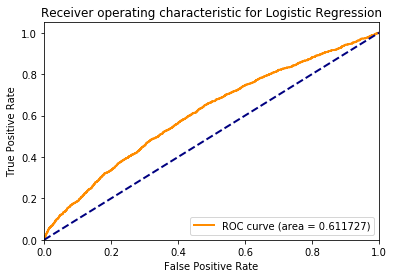

In [80]:
X_raw, y_raw = df[all_features], df['target']
clf = Classifier(X_raw=X_raw, y_raw=y_raw)
clf.input_scaling()
# get the logistic regression going
clf.logistic_regression(tuning=False)

In [ ]:
clf.random_forest()

Training a random forest model...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
